<a href="https://colab.research.google.com/github/janinerottmann/ITM22/blob/main/%C3%9Cbung4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

IT Management\ Janine Rottmann\ Lehrstuhl für Wirtschaftsinformatik und Systementwicklung

______________________


# Process Mining with Python tutorial: A healthcare application - Part 2

In [Part 1](https://colab.research.google.com/drive/1IBdY-Mgnz4WPGVD96J8COsNODTJCWJ_0#scrollTo=vTJKHoD-Vn15&line=8&uniqifier=1) of the tutorial, you saw how to prepare and explore your data to get a high level ‘feel’ for the processes. In this part you will learn how to use the pm4py library to discover process models by working with an example dataset (the same dataset as used to illustrate exploration in Part 1).

## Formatting the event log for PM4Py

The pm4py library works with both CSV/standard pandas dataframe and XES formats. XES is a standard format used to store event logs, but it is not adopted in all contexts. The two relevant objects are converter from pm4py.objects.conversion.log (here aliased log_converter), which converts standard pandas dataframes into event logs, and importer from pm4py.objects.log.importer.xes (here aliased xes_importer), which imports logs in XES format.




In [ ]:
# load pm4py library
import pm4py
from pm4py.objects.conversion.log import converter as log_converter 
from pm4py.objects.log.importer.xes import importer as xes_importer

Since in our worked example we are working with a CSV file, we only need the log_converter object. First we need to read the file into a pandas dataframe and decide which columns are the case, event and timestamp. We do this by mapping new pm4py-comprehensible column names to the columns. Recall our dataframe.

In [ ]:
# import pandas library
import pandas as pd

# Download the event log data.
events = pd.read_csv("https://raw.githubusercontent.com/janinerottmann/ITM22/main/data/ArtificialPatientTreatment.csv")
events.columns = ['patient', 'action', 'resource', 'datetime']
events['datetime'] = pd.to_datetime(events['datetime'])
events.head()

,patient,action,resource,datetime
0,patient 0,First consult,Dr. Anna,2017-01-02 11:40:11
1,patient 0,Blood test,Lab,2017-01-02 12:47:33
2,patient 0,Physical test,Nurse Jesse,2017-01-02 12:53:50
3,patient 0,Second consult,Dr. Anna,2017-01-02 16:21:06
4,patient 0,Surgery,Dr. Charlie,2017-01-05 13:23:09


Referring back to the previous part of the tutorial, we want to map: 

*   the ‘**patient**’ column to case, which for pm4py is the ‘**case:concept:name’ label**;
*   the ‘**datetime**’ column to timestamp, which for pm4py is the ‘**time:timestamp’ label**;
* the ‘**action**’ column as the event, which for pm4py is the ‘**concept:name**’ and
* the ‘**resource**’ column to resource, which for pm4py is the ‘**org:resource**’ label.

In [ ]:
# create a copy of the event log
eventlog = events.copy()

# rename eventlog columns
eventlog.rename(columns={'datetime': 'time:timestamp', 
                         'patient': 'case:concept:name', 
                         'action': 'concept:name', 
                         'resource': 'org:resource'}, inplace=True)

Then we use the log_converter object to convert it into the log format that pm4py recognises.

In [ ]:
## Convert to log format 
log = log_converter.apply(eventlog)

## Process discovery with Alpha Miner

Alpha miner is one of the most best-known process mining algorithms, and one of the first algorithms that could discover concurrency. The algorithm uses the ***direct succession, causal, parallel, and unrelated*** relationships between transitions in the log to discover a ***workflow net***. This page gives you a more thorough account of the algorithm and formal definitions of the relationships between transitions.

Alpha miner can be implemented very easily with the pm4py by importing the algorithm and applying it to the event log.

In [ ]:
## Import the alpha_miner algorithm
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
net, initial_marking, final_marking = alpha_miner.apply(log)

You can then represent this model with a petri net and visualise it with the pm4py visualizer object from pm4py.visualization.petrinet. If you are unfamiliar with petri nets, you should first watch this [introductory video](https://www.youtube.com/watch?v=EmYVZuczJ6k) before continuing.

# Exercises

* **Exercise 2.1: Petri nets were developed in the early 1960s by C.A. Petri and are used
to formally describe process flows. Create a Petri net to model the processes in the
clinic.**

/usr/local/lib/python3.7/dist-packages/pm4py/visualization/petrinet/__init__.py:20: UserWarning: please use the pm4py.visualization.petri_net package instead
  warnings.warn("please use the pm4py.visualization.petri_net package instead")
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  """


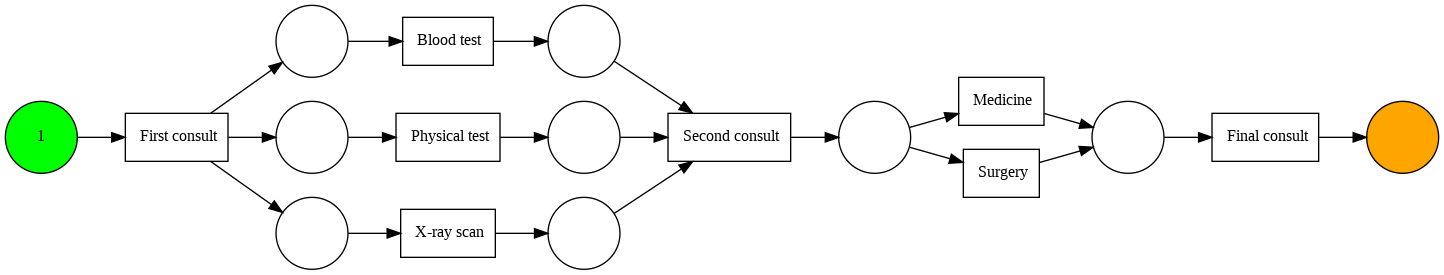

In [ ]:
## Import the petrinet visualizer object
from pm4py.visualization.petrinet import visualizer as pn_visualizer

# Visualise 
gviz = pn_visualizer.apply(net, initial_marking, final_marking) 
pn_visualizer.view(gviz)

You will notice that alpha miner has retained the ordering information so that Blood test, Physical test, and X-ray occur after First consult and before Second consult, and Medicine and Surgery occur after Second consult and before Final consult.

* **Exercise 2.2: Analyze the frequency of each transitions in the Petri net.**

To get an idea of the frequencies of the transitions, you can label the transitions by setting the variant parameter to pn_visualizer.Variants.FREQUENCY when calling pn_visualizer.apply().

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: DeprecatedWarning: apply is deprecated as of 2.2.5 and will be removed in 3.0.0. please use pm4py.visualization.petri_net.algorithm instead
  # Remove the CWD from sys.path while we load stuff.


replaying log with TBR, completed variants ::   0%|          | 0/15 [00:00<?, ?it/s]

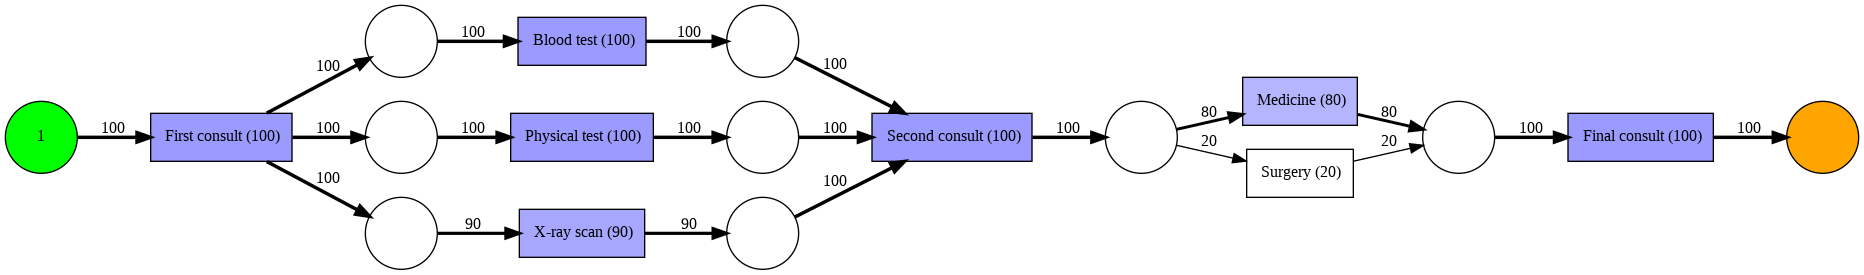

In [ ]:
# add information about frequency to the viz 
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: "png"}

# visualize petri net with information about frequency
gviz = pn_visualizer.apply(net, 
                           initial_marking, 
                           final_marking,
                           parameters=parameters,
                           variant=pn_visualizer.Variants.FREQUENCY,
                           log=log)
pn_visualizer.view(gviz)

The event frequencies recall the heatmap you generated in the previous part (but NB. alpha miner does not use the event frequencies to discover the model, see next part), where First consult, Blood test, Second consult, Physical test and Final consult were found to be the events shared by all patients (in the Petri net, these are the transitions shared by all processes), while Medicine, Surgery and X-ray scan are the differentiating events.

* **Exercise 2.3: In last week's tutorial, you already analyzed that not all patients go through the same processes in the clinic. If you now take a look at the resulting Petri net, what proportion of patients will only receive a medication (Event “Medicine”) and
what proportion of patients will be operated on (Event “Surgery”)?**

Answer: 80% of all patients receive only a drug, while 20% of all patients undergo surgery.
